In [2]:
import pandas as pd 
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
df = pd.read_csv(r"C:\Users\shafaimehr\PycharmProjects\Parcel-Delivery-Fraud\Parcel-Delivery_fraud_dataset.csv")
df.columns

Index(['driver_id', 'ride_id', 'pickup_time', 'dropoff_time', 'trip_distance',
       'trip_duration', 'status', 'payment_amount', 'rating', 'fraud_flag'],
      dtype='object')

In [10]:
# Count the number of unique drivers in the dataset
unique_drivers = df['driver_id'].nunique()
# Print the result
print(f"Number of unique drivers in the dataset: {unique_drivers}")

Number of unique drivers in the dataset: 200


In [8]:
# lists top 10 drivers with highest fraud rates.
df.groupby('driver_id')['fraud_flag'].mean().sort_values(ascending=False).head(10)

driver_id
D185    0.300000
D016    0.166667
D133    0.166667
D092    0.153846
D141    0.142857
D168    0.142857
D189    0.142857
D039    0.133333
D052    0.133333
D130    0.133333
Name: fraud_flag, dtype: float64

In [11]:
# Analyze the overall distribution of fraudulent vs. legitimate rides
# Shows what percentage of rides are labeled as fraud
fraud_distribution = df['fraud_flag'].value_counts(normalize=True) * 100
print(fraud_distribution)

fraud_flag
0    96.766667
1     3.233333
Name: proportion, dtype: float64


In [12]:
# Calculate fraud rates for each ride status (completed, canceled, suspicious)
# Helps to understand which statuses are more prone to fraud
fraud_by_status = df.groupby('status')['fraud_flag'].mean()
print(fraud_by_status)

status
canceled      0.0
completed     0.0
suspicious    1.0
Name: fraud_flag, dtype: float64


In [14]:
# Compare trip distance for fraudulent vs. legitimate rides
# Identifies if unusually short or long trips correlate with fraud
fraud_distance = df.groupby('fraud_flag')['trip_distance'].mean()
print(fraud_distance)

fraud_flag
0    12.858091
1     8.981032
Name: trip_distance, dtype: float64


In [15]:
# Add pickup hour and analyze fraud occurrence by time of day
# Reveals potential time patterns in fraudulent rides
df['pickup_hour'] = pd.to_datetime(df['pickup_time']).dt.hour
fraud_by_hour = df.groupby('pickup_hour')['fraud_flag'].mean()
print(fraud_by_hour)

pickup_hour
0     0.035088
1     0.039604
2     0.038168
3     0.046512
4     0.026786
5     0.059322
6     0.040816
7     0.030303
8     0.023810
9     0.018182
10    0.052239
11    0.025210
12    0.015873
13    0.023810
14    0.046875
15    0.040000
16    0.059829
17    0.037594
18    0.016260
19    0.008197
20    0.017241
21    0.030075
22    0.029851
23    0.013889
Name: fraud_flag, dtype: float64


In [17]:
# Create a summary table for each driver including total rides and fraud rate
# Provides a complete profile for fraud risk assessment
driver_summary = df.groupby('driver_id').agg(
    total_rides=('ride_id','count'),
    fraud_rate=('fraud_flag','mean')
).sort_values(by='fraud_rate', ascending=False)
print(driver_summary.head(10))

           total_rides  fraud_rate
driver_id                         
D185                10    0.300000
D016                12    0.166667
D133                12    0.166667
D092                13    0.153846
D141                14    0.142857
D168                14    0.142857
D189                21    0.142857
D039                15    0.133333
D052                15    0.133333
D130                15    0.133333


In [29]:
########## Scenario 1: Unusual Trip Duration
# Detect rides with abnormal trip duration compared to similar distances.
# Long or short durations may indicate fake trips or GPS manipulation.

df['duration_per_km'] = df['trip_duration'] / df['trip_distance']
Q1 = df['duration_per_km'].quantile(0.25)
Q3 = df['duration_per_km'].quantile(0.75)
IQR = Q3 - Q1
lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
suspicious_duration = df[(df['duration_per_km'] < lower) | (df['duration_per_km'] > upper)]

,driver_id,ride_id,pickup_time,dropoff_time,trip_distance,trip_duration,status,payment_amount,rating,fraud_flag,duration_per_km
11,D076,R0012,10/18/2025 2:36,10/18/2025 3:18,2.085455,42,completed,8.52,5,0,20.139491
14,D023,R0015,10/5/2025 22:16,10/5/2025 23:09,1.337916,53,suspicious,8.24,3,1,39.613855
16,D119,R0017,10/2/2025 22:54,10/2/2025 23:51,3.289843,57,completed,18.63,4,0,17.326056
28,D049,R0029,10/20/2025 12:08,10/20/2025 13:06,4.554086,58,completed,31.45,4,0,12.735815
29,D171,R0030,10/5/2025 7:35,10/5/2025 8:14,2.235490,39,completed,8.85,2,0,17.445839
...,...,...,...,...,...,...,...,...,...,...,...
2969,D127,R2970,10/16/2025 18:00,10/16/2025 18:52,2.028096,52,completed,7.09,4,0,25.639816
2970,D107,R2971,10/6/2025 5:48,10/6/2025 6:07,1.531359,19,suspicious,5.29,1,1,12.407281
2979,D010,R2980,10/5/2025 0:39,10/5/2025 1:34,3.839778,55,completed,19.34,4,0,14.323746
2987,D030,R2988,10/7/2025 15:33,10/7/2025 16:13,4.184369,40,completed,16.60,4,0,9.559386


In [31]:
########## Scenario 2: Payment Anomalies
# Identify rides where payment amount is inconsistent with trip distance.
# Possible fraud: fake payments, manipulated fare calculation.

df['payment_per_km'] = df['payment_amount'] / df['trip_distance']
Q1 = df['payment_per_km'].quantile(0.25)
Q3 = df['payment_per_km'].quantile(0.75)
IQR = Q3 - Q1
lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
suspicious_payment = df[(df['payment_per_km'] < lower) | (df['payment_per_km'] > upper)]

,driver_id,ride_id,pickup_time,dropoff_time,trip_distance,trip_duration,status,payment_amount,rating,fraud_flag,duration_per_km,payment_per_km


In [33]:
########## Scenario 3: Frequent Short Trips
# Detect drivers making many short-distance trips within a short time frame.
# May indicate fake self-deliveries or coordinated fraud.
short_trips = df[df['trip_distance'] < df['trip_distance'].quantile(0.25)]
suspicious_drivers = short_trips['driver_id'].value_counts().head(10)
suspicious_drivers

driver_id
D192    10
D151     9
D019     9
D093     8
D121     8
D052     8
D182     7
D075     7
D106     7
D181     7
Name: count, dtype: int64

In [35]:
########## Scenario 4: Abnormal Ratings After Trips
# Analyze driver ratings for extreme values following suspicious trips.
# Low or consistently perfect ratings might indicate manipulative behavior.

rating_stats = df.groupby('driver_id')['rating'].agg(['mean', 'count'])
suspicious_ratings = rating_stats[(rating_stats['mean'] < 2.5) | (rating_stats['mean'] > 4.9)]
suspicious_ratings

,mean,count
driver_id,,
D015,1.833333,6
D018,2.250000,16
D019,2.363636,22
D022,2.400000,10
D032,2.428571,14
D035,2.000000,14
D043,2.444444,9
D051,2.333333,9
D069,2.266667,15


In [37]:
########## Scenario 5: Cancelled or Incomplete Trips
# Identify drivers with high rates of cancelled or incomplete rides.
# High cancellation ratio may indicate misuse of the system or fake bookings.

cancel_ratio = df.groupby('driver_id')['status'].apply(lambda x: (x == 'cancelled').mean())
suspicious_cancel = cancel_ratio[cancel_ratio > 0.3]
suspicious_cancel

Series([], Name: status, dtype: float64)

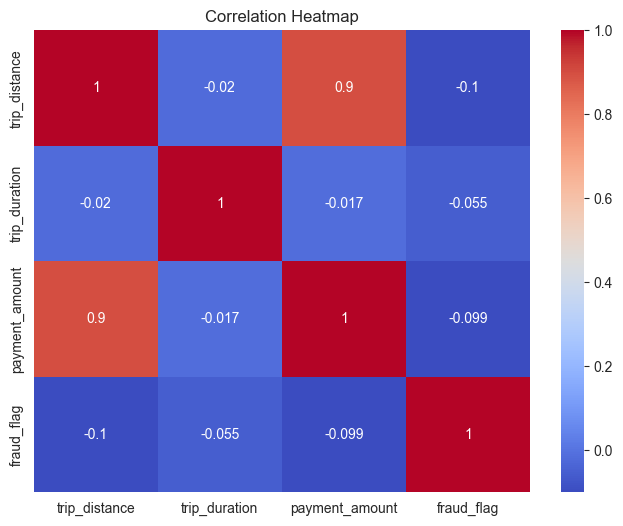

In [42]:
plt.figure(figsize=(8,6))
corr = df[['trip_distance','trip_duration','payment_amount','fraud_flag']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()
